In [1]:
import wave, numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd

# readfile
def audio_prep(file_name,txt_name,plot=1,listen=1,noise=0):
    fs,x_wave = wavfile.read(file_name)
    interval = np.genfromtxt(txt_name, delimiter='\t')
    

    
    x = x_wave.astype(float)
    if(noise>0):
        x += np.random.normal(0, x.max()*noise,x.shape)
        
    x_play = x.astype(int)    
    # spectrogram
    if(x.shape==(x.shape[0],)):
        f, t, Sxx = signal.spectrogram(x, fs,window=("hann"))
    else:
        f, t, Sxx = signal.spectrogram(x[:,0], fs,window=("hann"))
        


    #Sxx /= Sxx.max()
    #Sxx = -np.log(Sxx+1e-9)
    Sxx /= Sxx.max()
    labels = np.zeros(Sxx.shape[1])
    print("Sxx.shape=",Sxx.shape)
    
    print("\nRaw spectrogram")
    plt.pcolormesh(t, f, np.log(Sxx+1e-8))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
    print("interval.shape=",interval.shape)       
    if(interval.shape == (2,)):     
        if(listen==1):
            sd.play(x_play,fs,blocking=True)
        bb,ee = int(interval[0]*fs),min(int(interval[1]*fs),(x.shape[0]))
        print("interval=",interval)
        if(plot == 1):
            
            print("fs=",fs)
            print(x.shape)
            plt.plot(np.linspace(start=0,stop=(x_play.shape[0]/fs),num=x_play.shape[0]),\
                    np.linspace(start=0,stop=0,num=x_play.shape[0]))
            plt.plot(np.linspace(start=interval[0],stop=interval[1],num=int((interval[1]-interval[0])*fs)),\
                   x_play[bb:ee,0])
            plt.plot(np.linspace(start=0,stop=interval[0],num=int((interval[0])*fs)),\
                   x_play[0:bb,0])
            if(ee<x.shape[0]):
                plt.plot(np.linspace(start=interval[1],stop=x.shape[0]/fs,num=int((x.shape[0]-ee-1))),\
                   x_play[ee+1:,0])
            #plt.plot(np.linspace(start=0,stop=x.shape[0]/fs,num=int(x.shape[0])),x[:,0])
            plt.show()

        #Sxx  = 1-Sxx
        t_bb= int(t.shape[0]*bb/x_play.shape[0])+1
        t_ee= int(t.shape[0]*ee/x_play.shape[0])
        print("t_begin=",t_bb,"t_end=",t_ee)

        # laybel_gen - 0 is everything else, 1 is scream class            
        for i in range(t_bb,t_ee):
            labels[i] = 1

        for i in range(0,len(labels)):
            labels[i] = int(labels[i])
        print("1. Sxx.shape=",Sxx.shape) 
        Sxx = np.hstack((Sxx[:,max(int(t_bb/2),int(t_bb-300)):t_ee],Sxx[:,max(int(t_bb/3),int(t_bb-100)):t_ee]))
        labels = np.hstack((labels[max(int(t_bb/2),int(t_bb-300)):t_ee],labels[max(int(t_bb/3),int(t_bb-100)):t_ee]))
        t = np.linspace(start=0,stop=Sxx.shape[1],num =Sxx.shape[1])
        if(plot == 1):
            plt.plot(labels)           
            plt.show()
            plt.plot(Sxx.T[t_bb-1])
            plt.show()
        print("2. Sxx.shape=",Sxx.shape)     
        print("\nReturning spectrogram - single")
        plt.pcolormesh(t, f[0:int(Sxx.shape[0]*0.6)], np.log(Sxx[0:int(Sxx.shape[0]*0.6),:]+1e-8))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Number of frames')
        plt.show()
        return Sxx.T,labels,fs
    
    else:
        Sxx_prev = Sxx[:,0:2]
        labels_prev = np.zeros(Sxx_prev.shape[1])
        print("interval=",interval)
        print("fs=",fs)
        print(x.shape)
        prev_ee = 0;
        for j in range(0,interval.shape[0]):
            bb,ee = int(interval[j][0]*fs),int(interval[j][1]*fs)  

            # get the frame number of the starting and ending frames
            t_bb= int(t.shape[0]*bb/x_play.shape[0])+1
            t_ee= int(t.shape[0]*ee/x_play.shape[0])
            Sxx_prev = np.hstack((Sxx_prev, Sxx[:,max(prev_ee,int(t_bb-300)):min(Sxx.shape[1],t_ee)]))
            # laybel_gen - 0 is everything else, 1 is scream class            
            for i in range(t_bb,t_ee):
                labels[i] = 1
            for i in range(0,len(labels)):
                labels[i] = int(labels[i])
            
            labels_prev   = np.hstack((labels_prev,labels[max(prev_ee,int(t_bb-300)):min(Sxx.shape[1],t_ee)]))
            print("t_begin=",t_bb,"t_end=",t_ee)
            prev_ee = t_ee
            
        t_tmp = np.linspace(start=0,stop=Sxx_prev.shape[1],num =Sxx_prev.shape[1])
        #t_tmp = np.linspace(start=0,stop=Sxx_prev.shape[1]*x_play.shape[0]/t.shape[0]/fs,num =Sxx_prev.shape[1])
        print("\nReturning spectrogram - multiple")
        plt.pcolormesh(t_tmp, f[0:int(Sxx.shape[0]*0.6)],np.log(Sxx_prev[0:int(Sxx.shape[0]*0.6),:]+1e-8))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Number of frames')
        plt.show()
        
        return Sxx_prev.T,labels_prev,fs

In [2]:
def cross_train_prep(file_name,plot=1,listen=1):
    fs,x_wave = wavfile.read(file_name)
    
    x = x_wave.astype(float)
        
    x_play = x.astype(int)    
    # spectrogram
    if(x.shape==(x.shape[0],)):
        f, t, Sxx = signal.spectrogram(x, fs,window=("hann"))
    else:
        f, t, Sxx = signal.spectrogram(x[:,0], fs,window=("hann"))

    #Sxx /= Sxx.max()
    #Sxx = -np.log(Sxx+1e-9)
    Sxx /= Sxx.max()
    labels = np.zeros(Sxx.shape[1])
    print("Sxx.shape=",Sxx.shape)
    
    print("\nRaw spectrogram")
    plt.pcolormesh(t, f, np.log(Sxx+1e-8))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
     
    if(listen==1):
        sd.play(x_play,fs,blocking=True)

    return Sxx.T,labels,fs

In [3]:
def test_inference(file_name,txt_name,R_Net,listen=0,noise=0):
    Sxx_spec, labels,fs = audio_prep(file_name,txt_name,plot=0,listen=listen,noise=noise)
    Sxx_mfcc = Sxxin_to_mfcc(Sxx_spec,num_bank,fs,filter_bank)
    Sxx_mfcc /= Sxx_mfcc.max()
    Sxx_mfcc_diff = mfcc_difference(Sxx_mfcc)
    Sxx_spec = Sxx_spec[:, int(0.05*Sxx_spec.shape[1]):int(0.6*Sxx_spec.shape[1])]
    Sxx_in = np.hstack((Sxx_spec,Sxx_mfcc,Sxx_mfcc_diff))    
    result = [];
    compare = [];

    ps = 0 
    for i in range(0,Sxx_in.shape[0]):
        infer_in_enc = Sxx_in[ps+i]

        ret = R_Net.get_prob(infer_in_enc)
        result.append(ret)
        compare.append(labels[ps+i])

    plt.plot(result)
    plt.plot(compare)
    plt.show()
    print("error variance =",np.var(np.array(result)-np.array(compare)))

In [4]:
def get_mfcc_filter_bank(Sxx_in,num_bank,fs):
    m = np.linspace(start=1125 * np.log(1 + 10 / 700.0),stop=1125 * np.log(1 + fs*0.8 / 700.0),num=num_bank)
    # get list of freq centers
    print(m)
    f = np.zeros(len(m)+1)
    f[0:len(m)] = 700 * (np.exp(m / 1125) - 1)
    # get list of indices
    f = np.floor((Sxx_in.shape[1]+1)*f/fs)
    f[len(m)] = int(f[num_bank-1]*f[num_bank-1]/f[num_bank-2])
    print(f)
    # get coef for each filter bank for all time steps
    filter_bank = np.zeros((num_bank,Sxx_in.shape[1]))
    for i in range(0,num_bank):             
        for k in range(Sxx_in.shape[1]):           
            if(f[i-1] <= k and k <= f[i]):
                filter_bank[i][k] = (k-f[i-1]) / (f[i] - f[i-1]);#/(f[i+1] - f[i-1])*2
            elif(f[i] <= k and k <= f[i+1]):
                filter_bank[i][k] = (f[i+1]-k) / (f[i+1] - f[i]);#/(f[i+1] - f[i-1])*2
                
    return filter_bank;

def Sxxin_to_mfcc(Sxx_in,num_bank,fs,filter_bank):
    from scipy import fftpack
    mfcc_mat = np.zeros((Sxx_in.shape[0],num_bank)) # dim = (t,num_bank), same as Sxx_in

    for t in range(0,Sxx_in.shape[0]):
        mfcc_mat[t] = fftpack.dct(np.log(1e-15+np.dot(filter_bank,Sxx_in[t])))
    
    print(mfcc_mat.shape)
    return mfcc_mat;

def mfcc_difference(mfcc_mat):
    diff_mat = np.zeros_like(mfcc_mat);
    
    for t in range(1,mfcc_mat.shape[0]):
        diff_mat[t] = mfcc_mat[t] - mfcc_mat[t-1]
    return diff_mat

Sxx.shape= (129, 471)

Raw spectrogram


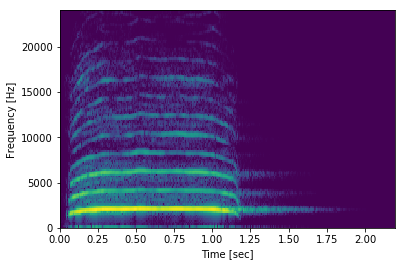

[  15.95771437  517.03431136 1018.11090835 1519.18750534 2020.26410233
 2521.34069933 3022.41729632 3523.49389331 4024.5704903  4525.6470873 ]
[  0.   1.   2.   5.   9.  15.  25.  41.  65. 104. 166.]


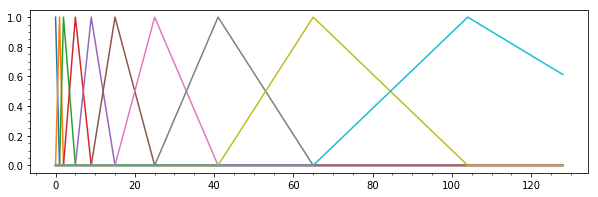

Test mfcc:
(471, 10)


array([[-4.33078277e+02,  1.21293669e+01, -1.14696548e+01, ...,
         9.21952300e-01, -3.03856815e+00, -4.34949517e+00],
       [-3.94763650e+02,  1.57609242e+01, -9.59010584e+00, ...,
        -2.03925290e+00, -3.29794670e+00, -3.07014910e+00],
       [-3.97925115e+02,  4.45646540e+00, -1.08924084e+01, ...,
         5.00315409e+00,  2.52209554e-01, -7.30489355e-01],
       ...,
       [-6.82018991e+02, -5.57063631e+00,  2.57767676e+00, ...,
        -4.58964083e-01,  2.13654350e-01,  4.32501385e-03],
       [-6.86160572e+02, -3.38675794e+00,  1.93496097e+00, ...,
        -4.75159170e-02, -1.70046067e-01,  3.20068936e-01],
       [-6.78665839e+02, -7.28474522e+00,  1.80667622e+00, ...,
         1.74711671e-01,  3.08471011e-01, -4.34347963e-01]])

In [5]:
# mfcc test
num_bank = 10
#Sxx_in,labels,fs = audio_prep("./audio_set/data/file_06001.wav","./audio_set/text/file_06.txt",plot=0,listen=0,noise=0)
Sxx_in,labels,fs = cross_train_prep("./audio_set/scream_data/file_00001.wav",plot=0,listen=0)
filter_bank = get_mfcc_filter_bank(Sxx_in[0:1],num_bank,fs)
plt.rcParams["figure.figsize"] = [10,3]
for i in range(num_bank):
    plt.plot(filter_bank[i])
plt.minorticks_on()
plt.show()
print("Test mfcc:")
Sxxin_to_mfcc(Sxx_in,num_bank,fs,filter_bank)

In [ ]:
epoch = 30*1000;
Sxx_spec,labels,fs = audio_prep("./audio_set/scream_data/file_00001.wav",\
                                "./audio_set/scream_text/file_00.txt",plot=1,listen=1,noise=0)

num_bank = 10
filter_bank = get_mfcc_filter_bank(Sxx_spec[0:1],num_bank,fs)

Sxx_mfcc = Sxxin_to_mfcc(Sxx_spec,num_bank,fs,filter_bank)
Sxx_mfcc /= Sxx_mfcc.max()
Sxx_mfcc_diff = mfcc_difference(Sxx_mfcc)
Sxx_spec = Sxx_spec[:, int(0.05*Sxx_spec.shape[1]):int(0.6*Sxx_spec.shape[1])]
Sxx_in = np.hstack((Sxx_spec,Sxx_mfcc,Sxx_mfcc_diff))

lenIn, lenOut, lenRec = Sxx_in.shape[1],2, min(150,max(min(100,Sxx_in.shape[0]),int(Sxx_in.shape[0]/10)))
sizeHidden, lenInRec, hiddenRec, numHiddenLayer = 100,Sxx_in.shape[1]-Sxx_mfcc_diff.shape[1],70, 1;
learningRate = 0.1;

print("lenIn=",lenIn, " lenOut=",lenOut,"lenInRec=",lenInRec, " lenRec=",lenRec)

In [7]:
#from LSTMbiDir import *
#from RNNbiDir import *
#from LSTMSingle import *
#from RNNSingle import *
from Hierarchical_FF_LSTM_RNN import *

In [10]:
# training
from os import listdir
from os.path import isfile, join

train_scream = 1; # 0 is train gunshot

if(train_scream == 1):
    txtpath = "./audio_set/scream_text/"
    datpath = "./audio_set/scream_data/"
    #cross_datpath = "./audio_set/gunshot/mix/"
else:
    txtpath = "./audio_set/gunshot/mix_text/"
    datpath = "./audio_set/gunshot/mix/"
    #cross_datpath = "./audio_set/scream_data/"
    
txtfiles = [f for f in listdir(txtpath) if isfile(join(txtpath, f))]
print(txtfiles)

datfiles = [f for f in listdir(datpath) if isfile(join(datpath, f))]
print(datfiles)

#cross_files = [f for f in listdir(cross_datpath) if isfile(join(cross_datpath, f))]
#print(cross_files)


# Initialization
Sxx_spec,labels,fs = audio_prep(datpath+datfiles[0],txtpath+txtfiles[0],plot=0,listen=0,noise=0)           
Sxx_mfcc = Sxxin_to_mfcc(Sxx_spec,num_bank,fs,filter_bank)
Sxx_mfcc /= Sxx_mfcc.max()
Sxx_mfcc_diff = mfcc_difference(Sxx_mfcc)
Sxx_spec = Sxx_spec[:, int(0.05*Sxx_spec.shape[1]):int(0.6*Sxx_spec.shape[1])]+1e-15
Sxx_in = np.hstack((Sxx_spec,Sxx_mfcc,Sxx_mfcc_diff))
    
    
# Hiearchical FF_LSTM_RNN
dropout_threshold = 0.1;
R = hFFLSTMRNN(lenIn, lenOut, lenRec, sizeHidden, lenInRec,\
               hiddenRec, Sxx_in, labels, learningRate,dropout_threshold); biDir = 0;lstm=1 

# single LSTM
#dropout_threshold = 0.1;
#R = myRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate,dropout_threshold); biDir = 0;lstm=1 

# bidir LSTM
#R = lstmRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 1;lstm=1 

# single RNN
#R = basicRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 0;lstm = 0 

# bidir RNN
#R = basicRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 1;lstm = 0 

n,k,training_count,position,time,correctness = 0,0,0,0,0,0;


while n<epoch:
    training_count += 1;
    R.learningRate = 0.05+0.05*np.exp(-training_count/(100*1000))
    R.dropout_threshold = 0.7-0.65*np.exp(-training_count/(100*1000))
    
    if(position+lenRec+1 >= Sxx_in.shape[0] or n == 0 or n > 2000):
        #if((time > 50 and n > 100) or (time > 10 and n > 1000) or correctness > 0.95):
        if((time > 1) or correctness > 0.95):
            
            k = int(np.random.random()*len(txtfiles)/2)
            if(k == len(txtfiles)):
                k = 0;
            n = int(1+n/113)*113
            #m = int(np.random.random()*len(cross_files))
            
            if(n > 20*113):
                print("test inference:",datfiles[k])
                test_inference(datpath+datfiles[k],\
                               txtpath+txtfiles[k],\
                               R,listen=0,noise=0.02)
            if(int(np.random.random()*100) % 3 > 0):
                print("same class train")
                Sxx_spec,labels,fs = audio_prep(datpath+datfiles[k],\
                                                txtpath+txtfiles[k],plot=0,listen=0,noise=0)
                print("n =",n,",k updates! k = ",k,"New Sxx has length ",Sxx_in.shape[0])
                print(datpath+datfiles[k])
            else:
                print("same class train")
                Sxx_spec,labels,fs = audio_prep(datpath+datfiles[k],\
                                                txtpath+txtfiles[k],plot=0,listen=0,noise=0)
                print("n =",n,",k updates! k = ",k,"New Sxx has length ",Sxx_in.shape[0])
                print(datpath+datfiles[k])
                #print("cross class train")
                #cross_file_name = cross_datpath+cross_files[m]
                #Sxx_spec,labels,fs = cross_train_prep(cross_file_name,plot=0,listen=0)
                
            Sxx_mfcc = Sxxin_to_mfcc(Sxx_spec,num_bank,fs,filter_bank)
            Sxx_mfcc /= Sxx_mfcc.max()
            Sxx_mfcc_diff = mfcc_difference(Sxx_mfcc)
            Sxx_spec = Sxx_spec[:, int(0.05*Sxx_spec.shape[1]):int(0.6*Sxx_spec.shape[1])]+1e-15
            Sxx_in = np.hstack((Sxx_spec,Sxx_mfcc,Sxx_mfcc_diff))
                    
            time = 0
            correctness = 0
            
        if(biDir == 0):
            R.h = np.zeros_like(R.h)
            if(lstm != 0):
                R.c = np.zeros_like(R.c)
        else:
            R.hls_infer = np.zeros_like(R.hls_infer)
            R.hrs_infer = np.zeros_like(R.hrs_infer)
            if(lstm != 0):
                R.cls_infer = np.zeros_like(R.cls_infer)
                R.crs_infer = np.zeros_like(R.crs_infer)
        position = 0;
        time += 1;
        
    inputs  = Sxx_in[position:position+lenRec]
    targets  = labels[position:position+lenRec]

    R.update_inputs_targets(inputs,targets)
    R.fwd_pass();
    
    err = R.bwd_pass();
    
    if(n%113 == 0 ): # 113 is a prime number
        print("times:",time,"n=",n,"err:",err)
        print(" LearningRate:", R.learningRate,"Dropout_threshold:",R.dropout_threshold)
        result = []
        compare = []
        count, correct = 0,0;
        ps = 0 
        if(biDir == 0):
            # single layer
            for i in range(0,Sxx_in.shape[0]):
                
                infer_in_enc = Sxx_in[ps+i]
                ret = R.get_prob(infer_in_enc)
                count += 1
                if(abs(ret-labels[ps+i]) <= 0.5):
                    correct += 1;
                result.append(ret)
                compare.append(labels[ps+i])
            print("single layer: correctness = ",correct/count*100,"%","correct=",correct,"count=",count)
            correctness = correct/count
        else:
            # bi-directional
            while(ps+lenRec<Sxx_in.shape[0]):
                infer_in_enc  = Sxx_in[ps:ps+lenRec,:];
                ret = R.inference(infer_in_enc)     
                result.append(ret[:,1])
                count += ret.shape[0];
                for j in range(ret.shape[0]):
                    if(abs(labels[ps:ps+j]-ret[j,1]) <= 0.5):
                        correct += 1;
                compare.append(list(labels[ps:ps+lenRec])[:])
                ps += lenRec
            compare = np.array(compare)
            compare = np.reshape(compare,(compare.shape[0]*compare.shape[1],1))
            result = np.array(result)
            result = np.reshape(result,(result.shape[0]*result.shape[1],1))
            print("biDir layer: correctness = ",correct/count*100,"%","correct=",correct,"count=",count)
            correctness = correct/count
        plt.plot(compare)
        plt.plot(result)
        
        plt.show()
    position += lenRec;
    n += 1;

['file_00.txt', 'file_11.txt', 'file_15.txt', 'file_17.txt']
['file_00001.wav', 'file_11001.wav', 'file_15001.wav', 'file_17001.wav']
Sxx.shape= (129, 471)

Raw spectrogram


KeyboardInterrupt: 

In [ ]:
datfiles = "file_06001.wav"
txtfiles = "file_06.txt"
for i in range(0,5):
    test_inference("./audio_set/scream_data/"+datfiles,"./audio_set/scream_text/"+txtfiles,R,listen=0,noise=i/20)

In [ ]:
from os import listdir
from os.path import isfile, join
txtpath = "./audio_set/scream_text/"
datpath = "./audio_set/scream_data/"
txtfiles = [f for f in listdir(txtpath) if isfile(join(txtpath, f))]
print(txtfiles)
datfiles = [f for f in listdir(datpath) if isfile(join(datpath, f))]
print(datfiles)
for k in range(len(txtfiles)):
    print("./audio_set/scream_data/"+datfiles[k])
    Sxx,lb,fs = audio_prep("./audio_set/scream_data/"+datfiles[k],"./audio_set/scream_text/"+txtfiles[k],plot=0,listen=0,noise=0)
    plt.plot(lb)
    plt.ylabel("label\n")
    plt.show()

In [ ]:
datfiles = "file_32001.wav"
txtfiles = "file_32.txt"
Sxx,lb,fs = audio_prep("./audio_set/scream_data/"+datfiles,"./audio_set/scream_text/"+txtfiles,plot=0,listen=0,noise=0)
plt.plot(lb)
plt.ylabel("label\n\n")
plt.show()

In [ ]:
print("./audio_set/scream_data/"+datfiles[k])